In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import h1, h2
from generate_graphs import generate_erdos_renyi, generate_data

### Generate graph and data

In [2]:
# generate precision matrix
n, p = 500, 1000
n_prop_to_p = [0.5]
edge_prob = 0.15
Theta, Sigma = generate_erdos_renyi(p, n_prop_to_p, type='peng', edge_prob=edge_prob, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2022)

# generate data
Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2022)
X = Xs[0]
S = np.cov(X, rowvar=False)

### Get $\Omega^*$

In [4]:
# get omega_star from accord and concord
# lam=0.08 for sparsity=3%
# lam=0.05 for sparsity=15%
lam = 0.05

model_accord = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=2, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_accord.fit(X)
Omega_star_accord = model_accord.omega_.toarray()

# use a small step size for concord to be conservative
model_concord = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, constant_stepsize=0.25, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_concord.fit(X)
Omega_star_concord = model_concord.omega_.toarray()

In [3]:
# save Omega_star
# pickle.dump(Omega_star_accord, open('data/Omega_star_accord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))
# pickle.dump(Omega_star_concord, open('data/Omega_star_concord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))

# load Omega_star
lam = 0.05
Omega_star_accord = pickle.load(open('data/Omega_star_accord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))
Omega_star_concord = pickle.load(open('data/Omega_star_concord_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))

### Get ACCORD convergence results

In [6]:
# objective computed at omega_star
obj_omega_star = h1(Omega_star_accord, S, lam2=0.0) + h2(Omega_star_accord, lam)


# ACCORD with a fixed step size of 1/L
model_accord_1L = GraphicalAccord(Omega_star=Omega_star_accord, lam1=lam, lam2=0.0, stepsize_multiplier=1, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_accord_1L.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_1L = [np.linalg.norm(np.eye(p) - Omega_star_accord)]
obj_accord_1L = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_1L.hist_)):
    norm_accord_1L.append(model_accord_1L.hist_[i][2])
    obj_accord_1L.append(model_accord_1L.hist_[i][0])
obj_diff_accord_1L = obj_accord_1L - obj_omega_star

# ACCORD with a fixed step size of 1.9/L
# model_accord_19L = GraphicalAccord(Omega_star=Omega_star_accord, lam1=lam, lam2=0.0, stepsize_multiplier=1.9, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
# model_accord_19L.fit(X)

# # || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
# norm_accord_19L = [np.linalg.norm(np.eye(p) - Omega_star_accord)]
# obj_accord_19L = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
# for i in range(len(model_accord_19L.hist_)):
#     norm_accord_19L.append(model_accord_19L.hist_[i][2])
#     obj_accord_19L.append(model_accord_19L.hist_[i][0])
# obj_diff_accord_19L = obj_accord_19L - obj_omega_star


# ACCORD with backtracking with lower bound of 1/L
model_accord_1L_backtracking = GraphicalAccord(Omega_star=Omega_star_accord, lam1=lam, lam2=0.0, stepsize_multiplier=1, backtracking=True, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_accord_1L_backtracking.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_accord_1L_backtracking = [np.linalg.norm(np.eye(p) - Omega_star_accord)]
obj_accord_1L_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_accord_1L_backtracking.hist_)):
    norm_accord_1L_backtracking.append(model_accord_1L_backtracking.hist_[i][3])
    obj_accord_1L_backtracking.append(model_accord_1L_backtracking.hist_[i][1])
obj_diff_accord_1L_backtracking = obj_accord_1L_backtracking - obj_omega_star

# ACCORD with backtracking with lower bound of 1.9/L
# model_accord_19L_backtracking = GraphicalAccord(Omega_star=Omega_star_accord, lam1=lam, lam2=0.0, stepsize_multiplier=1.9, backtracking=True, epstol=1e-15, maxitr=1000, penalize_diag=True)
# model_accord_19L_backtracking.fit(X)

# # || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
# norm_accord_19L_backtracking = [np.linalg.norm(np.eye(p) - Omega_star_accord)]
# obj_accord_19L_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
# for i in range(len(model_accord_19L_backtracking.hist_)):
#     norm_accord_19L_backtracking.append(model_accord_19L_backtracking.hist_[i][3])
#     obj_accord_19L_backtracking.append(model_accord_19L_backtracking.hist_[i][1])
# obj_diff_accord_19L_backtracking = obj_accord_19L_backtracking - obj_omega_star

In [8]:
# save results
np.savetxt('data/norm_accord_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_1L, fmt='%s', delimiter=',')
np.savetxt('data/obj_diff_accord_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_1L, fmt='%s', delimiter=',')

# np.savetxt('data/norm_accord_19L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_19L, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_19L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_19L, fmt='%s', delimiter=',')

np.savetxt('data/norm_accord_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_1L_backtracking, fmt='%s', delimiter=',')
np.savetxt('data/obj_diff_accord_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_1L_backtracking, fmt='%s', delimiter=',')

# np.savetxt('data/norm_accord_19L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_accord_19L_backtracking, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_accord_19L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_accord_19L_backtracking, fmt='%s', delimiter=',')

### Get CONCORD convergence results

In [11]:
# objective computed at omega_star
obj_omega_star = h1(Omega_star_concord, S, lam2=0.0) + h2(Omega_star_concord, lam)


# CONCORD with fixed step size of 0.25
constant_stepsize = 0.25
model_concord_025 = GraphicalConcord(Omega_star=Omega_star_concord, lam1=lam, lam2=0.0, constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_concord_025.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_concord_025 = [np.linalg.norm(np.eye(p) - Omega_star_concord)]
obj_concord_025 = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_concord_025.hist_)):
    norm_concord_025.append(model_concord_025.hist_[i][2])
    obj_concord_025.append(model_concord_025.hist_[i][0])
obj_diff_concord_025 = obj_concord_025 - obj_omega_star


# CONCORD with fixed step size of 0.75
constant_stepsize = 0.75
model_concord_075 = GraphicalConcord(Omega_star=Omega_star_concord, lam1=lam, lam2=0.0, constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_concord_075.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_concord_075 = [np.linalg.norm(np.eye(p) - Omega_star_concord)]
obj_concord_075 = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_concord_075.hist_)):
    norm_concord_075.append(model_concord_075.hist_[i][2])
    obj_concord_075.append(model_concord_075.hist_[i][0])
obj_diff_concord_075 = obj_concord_075 - obj_omega_star


# CONCORD with fixed step size of 0.85
# constant_stepsize = 0.85
# model_concord_085 = GraphicalConcord(Omega_star=Omega_star_concord, lam1=lam, lam2=0.0, constant_stepsize=constant_stepsize, backtracking=False, epstol=1e-15, maxitr=1000, penalize_diag=True)
# model_concord_085.fit(X)

# # || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
# norm_concord_085 = [np.linalg.norm(np.eye(p) - Omega_star_concord)]
# obj_concord_085 = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
# for i in range(len(model_concord_085.hist_)):
#     norm_concord_085.append(model_concord_085.hist_[i][2])
#     obj_concord_085.append(model_concord_085.hist_[i][0])
# obj_diff_concord_085 = obj_concord_085 - obj_omega_star

In [4]:
# CONCORD with backtracking
model_concord_backtracking = GraphicalConcord(Omega_star=Omega_star_concord, lam1=lam, lam2=0.0, constant_stepsize=0.5, backtracking=True, epstol=1e-15, maxitr=1000, penalize_diag=True)
model_concord_backtracking.fit(X)

# || Omega^(t) - Omega^* || and || l(Omega^(t)) - l(Omega^*) ||
norm_concord_backtracking = [np.linalg.norm(np.eye(p) - Omega_star_concord)]
obj_concord_backtracking = [h1(np.eye(p), S, lam2=0.0) + h2(np.eye(p), lam)]
for i in range(len(model_concord_backtracking.hist_)):
    norm_concord_backtracking.append(model_concord_backtracking.hist_[i][3])
    obj_concord_backtracking.append(model_concord_backtracking.hist_[i][1])
obj_diff_concord_backtracking = obj_concord_backtracking - obj_omega_star

NameError: name 'obj_omega_star' is not defined

In [ ]:
# save results
# np.savetxt('data/norm_concord_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_concord_025, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_concord_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_concord_025, fmt='%s', delimiter=',')

# np.savetxt('data/norm_concord_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_concord_075, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_concord_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_concord_075, fmt='%s', delimiter=',')

# np.savetxt('data/norm_concord_085_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_concord_085, fmt='%s', delimiter=',')
# np.savetxt('data/obj_diff_concord_085_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_concord_085, fmt='%s', delimiter=',')

np.savetxt('data/norm_concord_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', norm_concord_backtracking, fmt='%s', delimiter=',')
np.savetxt('data/obj_diff_concord_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', obj_diff_concord_backtracking, fmt='%s', delimiter=',')

### Load

In [ ]:
# load
norm_accord_1L = np.genfromtxt('data/norm_accord_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# norm_accord_19L = np.genfromtxt('data/norm_accord_19L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_accord_1L_backtracking = np.genfromtxt('data/norm_accord_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# norm_accord_19L_backtracking = np.genfromtxt('data/norm_accord_19L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_concord_025 = np.genfromtxt('data/norm_concord_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_concord_075 = np.genfromtxt('data/norm_concord_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# norm_concord_085 = np.genfromtxt('data/norm_concord_085_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
norm_concord_backtracking = np.genfromtxt('data/norm_concord_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')

obj_diff_accord_1L = np.genfromtxt('data/obj_diff_accord_1L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# obj_diff_accord_19L = np.genfromtxt('data/obj_diff_accord_19L_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_accord_1L_backtracking = np.genfromtxt('data/obj_diff_accord_1L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# obj_diff_accord_19L_backtracking = np.genfromtxt('data/obj_diff_accord_19L_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_concord_025 = np.genfromtxt('data/obj_diff_concord_025_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_concord_075 = np.genfromtxt('data/obj_diff_concord_075_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
# obj_diff_concord_085 = np.genfromtxt('data/obj_diff_concord_085_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')
obj_diff_concord_backtracking = np.genfromtxt('data/obj_diff_concord_backtracking_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.txt', delimiter=',')

### Take objective values up to 5e-11

In [ ]:
### Take objective values up to 5e-11
threshold = 5e-11
ls = [obj_diff_accord_1L, obj_diff_accord_1L_backtracking,
      obj_diff_concord_025, obj_diff_concord_075, obj_diff_concord_backtracking]      
for i in range(len(ls)):
    last_indx = np.where(ls[i] > threshold)[0][-1]
    ls[i] = ls[i][:last_indx+1]

obj_diff_accord_1L = ls[0]
obj_diff_accord_1L_backtracking = ls[1]
obj_diff_concord_025 = ls[2]
obj_diff_concord_075 = ls[3]
obj_diff_concord_backtracking = ls[4]

### Visualization (3% sparsity)

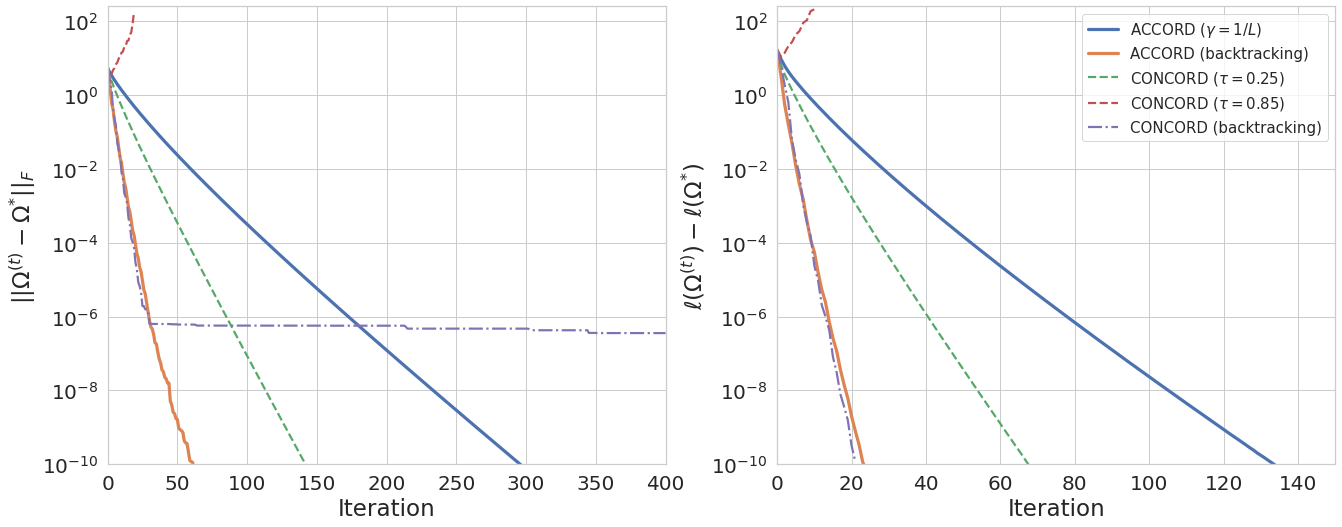

In [12]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(norm_accord_1L)), norm_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_1L_backtracking)), norm_accord_1L_backtracking, label=r'ACCORD (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_concord_025)), norm_concord_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_concord_085)), norm_concord_085, label=r'CONCORD ($\tau=0.85$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_concord_backtracking)), norm_concord_backtracking, label=r'CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].set_yscale('log', base=10)
axes[i].set_xlim((0,300))
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_accord_1L)), obj_diff_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_1L_backtracking)), obj_diff_accord_1L_backtracking, label=r'ACCORD (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_concord_025)), obj_diff_concord_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_concord_085)), obj_diff_concord_085, label=r'CONCORD ($\tau=0.85$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_concord_backtracking)), obj_diff_concord_backtracking, label='CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].legend(fontsize=15, loc='upper right')
axes[i].set_xlim((0,140))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23)

# fig.subplots_adjust(top=0.92)
# plt.savefig('../output/convergence-sp' + str(edge_prob)[3:], bbox_inches='tight');

### Visualization (15% sparsity)

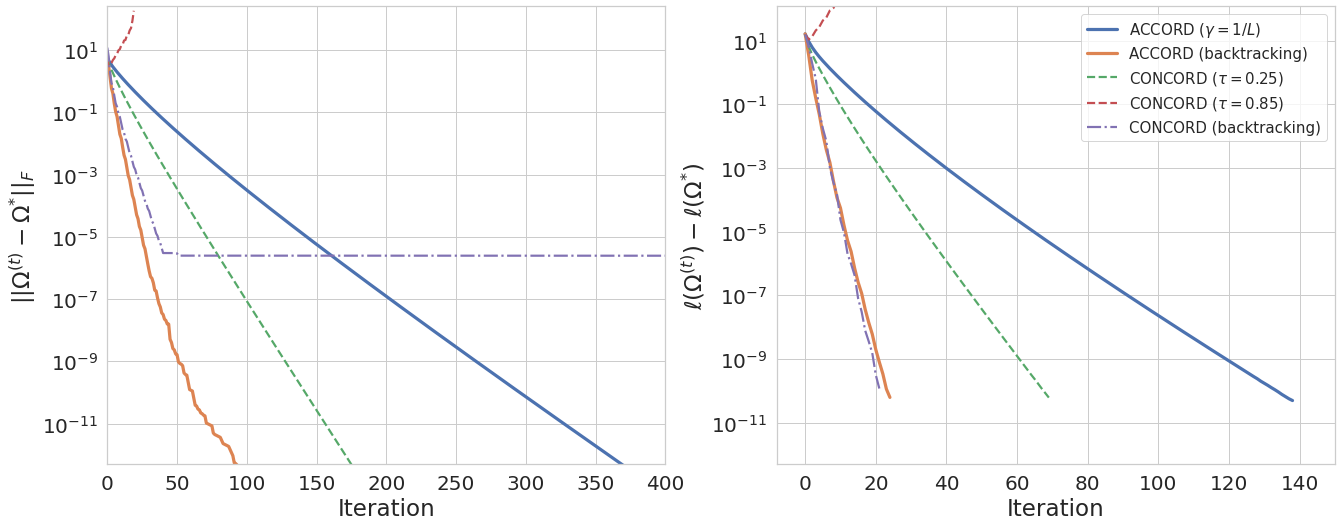

In [ ]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(np.arange(len(norm_accord_1L)), norm_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_accord_1L_backtracking)), norm_accord_1L_backtracking, label=r'ACCORD (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(norm_concord_025)), norm_concord_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_concord_075)), norm_concord_075, label=r'CONCORD ($\tau=0.75$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(norm_concord_backtracking)), norm_concord_backtracking, label=r'CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].set_yscale('log', base=10)
axes[i].set_xlim((0,1000))
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_accord_1L)), obj_diff_accord_1L, label=r'ACCORD ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_accord_1L_backtracking)), obj_diff_accord_1L_backtracking, label=r'ACCORD (backtracking)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_concord_025)), obj_diff_concord_025, label=r'CONCORD ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_concord_075)), obj_diff_concord_075, label=r'CONCORD ($\tau=0.75$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_concord_backtracking)), obj_diff_concord_backtracking, label='CONCORD (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].legend(fontsize=15, loc='upper right')
axes[i].set_xlim((0,400))
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((10**(-10),250))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23)

fig.subplots_adjust(top=0.92)
plt.savefig('../output/convergence-sp' + str(edge_prob)[3:], bbox_inches='tight');